In [35]:
pip install --upgrade torchio

In [36]:
pip install torchio[plot]

In [37]:
import torch
import torchio as tio
from torch.utils.data import DataLoader


# 1: Dataset IXI


* Download a public dataset (IXI for example, https://brain-development.org/ixi-dataset/), a small subset is totally fine (T1 or T2);
* Use the "torchio" library to load the data

 















In [38]:
ixi_dataset=tio.datasets.IXI('path/to/ixi_root/',download=True,modalities=('T1', ),)

In [39]:
print('Number of subjects in dataset:', len(ixi_dataset))  # 581

Number of subjects in dataset: 581


In [40]:
sample_subject = ixi_dataset[0]
print('Keys in subject sample:', tuple(sample_subject.keys()))  # ('T1',)

Keys in subject sample: ('subject_id', 'T1')


In [41]:
print('Shape of T1 data:', sample_subject['T1'][tio.DATA].shape)  # [1, 256, 256, 150]

Shape of T1 data: torch.Size([1, 256, 256, 150])


In [42]:
from pathlib import Path
images_dir = Path('path/to/ixi_root/T1')
print(type(images_dir))
print(images_dir)

<class 'pathlib.PosixPath'>
path/to/ixi_root/T1


In [43]:
image_paths = sorted(images_dir.glob('*.nii.gz'))

In [44]:
subjects = []
for (image_path) in zip(image_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 581 subjects


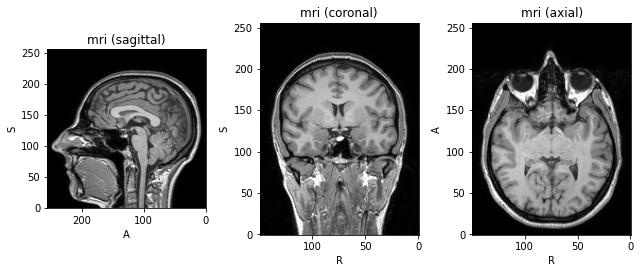

Subject(Keys: ('mri',); images: 1)
ScalarImage(shape: (1, 256, 256, 150); spacing: (0.94, 0.94, 1.20); orientation: PSR+; dtype: torch.ShortTensor; memory: 18.8 MiB)


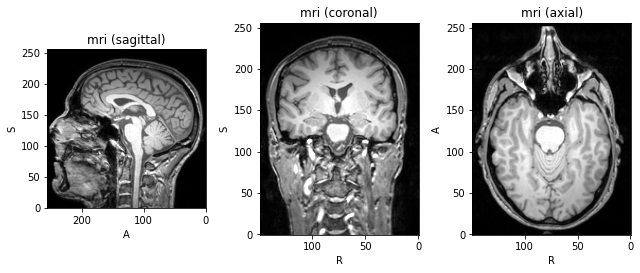

Subject(Keys: ('mri',); images: 1)
ScalarImage(shape: (1, 256, 256, 150); spacing: (0.94, 0.94, 1.20); orientation: PSR+; dtype: torch.FloatTensor; memory: 37.5 MiB)


In [45]:
one_subject = dataset[0]
one_subject.plot(figsize=(9, 4))
print(one_subject)
print(one_subject.mri)
two_subject = dataset[1]
two_subject.plot(figsize=(9, 4))
print(two_subject)
print(two_subject.mri)





# 2.Transforms

 Apply at least "ONE" degradation algorithm (noise, motion corruption, field inhomogeneities, etc), using torchio 




*   Random Motion
*   RandomNoise
*   RandomBlur












In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm


In [46]:
#@title Histograms
paths = image_paths
compute_histograms = False
def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for path in tqdm(paths):
        tensor = tio.ScalarImage(path).data
        if 'HH' in path.name: color = 'red'
        elif 'Guys' in path.name: color = 'green'
        elif 'IOP' in path.name: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004);
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/daqsg3udk61v65i/hist_original.png?dl=1')
graph

In [47]:
histogram_landmarks_path = 'landmarks.npy'
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

100%|██████████| 581/581 [03:23<00:00,  2.85it/s]


Trained landmarks: [  0.      0.      0.005   0.024   0.083   0.37    1.324   8.087  30.294
  40.854  48.852  65.085 100.   ]


In [48]:
#@title Histograms after histogram_transform
if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i ,sample in enumerate(tqdm(dataset)):
        standard = histogram_transform(sample)
        tensor = standard.mri.data
        path = str(sample.mri.path)
        if 'HH' in path: color = 'red'
        elif 'Guys' in path: color = 'green'
        elif 'IOP' in path: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 0.02)
    ax.set_title('Intensity values of all samples after histogram standardization')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/dqqaf78c86mrsgn/hist_standard.png?dl=1')
graph

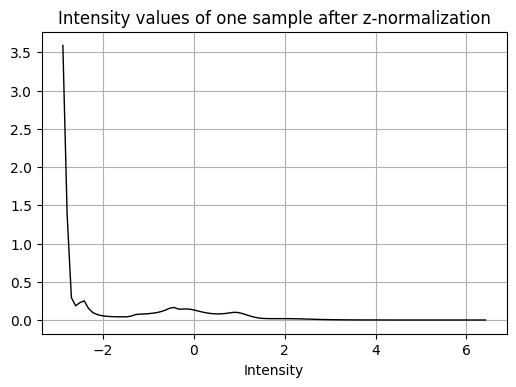

In [49]:
#@title Testing transform [histogram_transform, znorm_transform]
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.mri.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()

In [63]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),#Add Gaussian noise with parameters.
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),#Add Gaussian noise with parameters.
    tio.OneHot(),
])

# 3.Training neural network

In [64]:
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

real_set=tio.SubjectsDataset(training_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 522 subjects
Validation set: 59 subjects


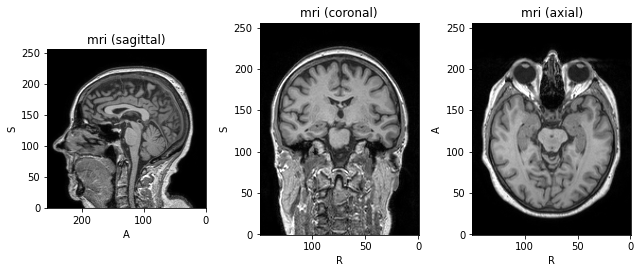

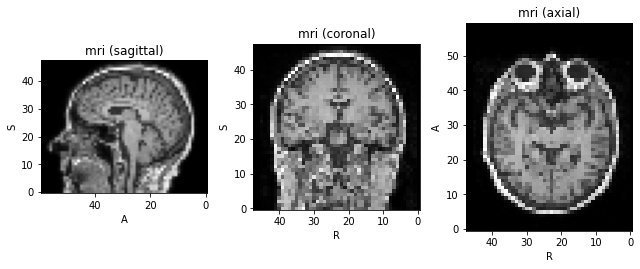

In [65]:
real = real_set[42]  # transform is NOT applied 
real.plot(figsize=(9, 4))
training_instance = training_set[42]  # transform is applied inside SubjectsDataset
training_instance.plot(figsize=(9, 4))

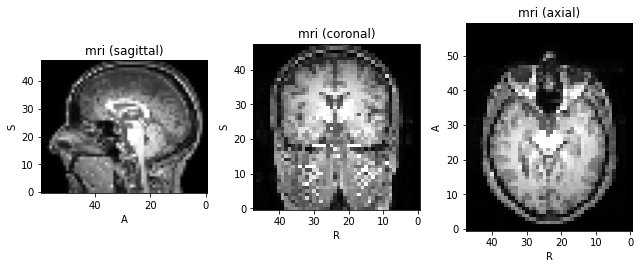

In [66]:
validation_instance = validation_set[42]
validation_instance.plot(figsize=(9, 4))

In [67]:
import multiprocessing
num_workers = multiprocessing.cpu_count()
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=False,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

In [68]:
!pip install unet

In [69]:
#@title Deep Learning Model
import enum
import time
from unet import UNet
add_noise = tio.RandomNoise()
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch,device):
    inputs = batch['mri'][tio.DATA].to(device)
    return inputs

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs = prepare_batch(batch,device)
        optimizer.zero_grad()        
        with torch.set_grad_enabled(is_training):
            outputs = model(inputs)                     
            criterion=torch.nn.L1Loss(reduction='mean')
            batch_losses = criterion(outputs, inputs)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([32, 1, 48, 60, 48])) that is different to the input size (torch.Size([32, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([27, 1, 48, 60, 48])) that is different to the input size (torch.Size([27, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation mean loss: 1.943
Starting epoch 1


  0%|          | 0/33 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([16, 1, 48, 60, 48])) that is different to the input size (torch.Size([16, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([10, 1, 48, 60, 48])) that is different to the input size (torch.Size([10, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training mean loss: 1.649


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 1.652
Starting epoch 2


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 1.378


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 1.330
Starting epoch 3


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 1.086


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.956
Starting epoch 4


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.732


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.483
Starting epoch 5


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.408


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.409
Starting epoch 6


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.216


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.245
Starting epoch 7


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.125


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.221
Starting epoch 8


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.095


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.101
Starting epoch 9


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.086


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.102
Starting epoch 10


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.078


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.070


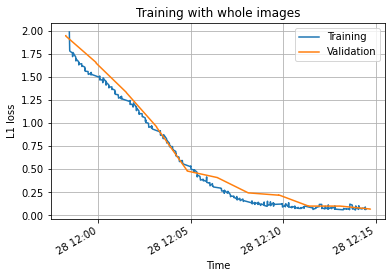

In [73]:
train_whole_images = True 
num_epochs = 10
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = '/content/whole_images_epoch_9.pth'# TODO :: update the weight_url in case 'train_whole_images = False'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('L1 loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

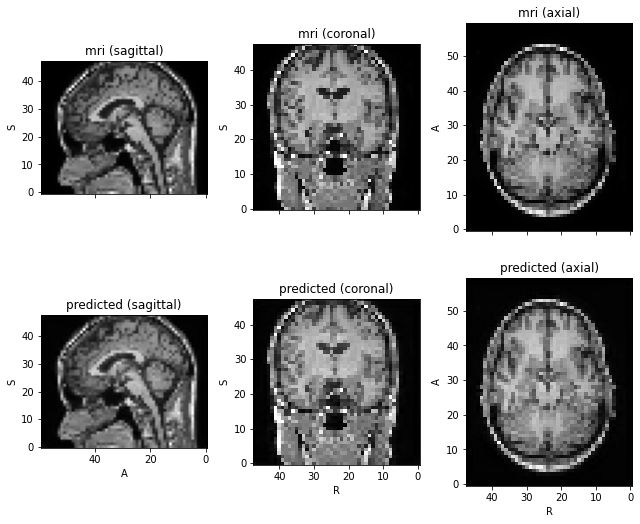

In [74]:
batch = next(iter(validation_loader))
model.eval()
inputs = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    out_image = model(inputs).cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=out_image[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'gray'})